# Example for the Memory Augmented Generator (MAG) model

## Imports + model initialization

In [1]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm

from loggers import set_level, add_handler, TIME_LEVEL
from models.qa import MAG
from utils.text import TextEncoder
from utils import plot, plot_multiple, plot_embedding, plot_confusion_matrix, set_display_options
from datasets import get_dataset, prepare_dataset, train_test_split, test_dataset_time
from models.weights_converter import partial_transfer_learning

#set_level(TIME_LEVEL)
set_display_options()

model_name = 'm3_nq_mag_off_entq_ct_wt_ib_2_8_dense'
bert_base  = 'facebook/bart-large'

print("Tensorflow version : {}".format(tf.__version__))

Tensorflow version : 2.5.0


In [ ]:
step, idx, mode = model_name.split('_')[-3 :]

config = {
    'lang'             : 'en',
    'output_format'    : '{answer}',
    'question_format'  : '{question}',
    'context_format'   : '{context}' if 'ct' not in model_name else '{title}{sep_token}{context}',
    'text_encoder'     : TextEncoder.from_transformers_pretrained(bert_base),
    'max_input_length' : 512,
    'max_output_length': 128,
    'context_offset'   : 128 if 'off' in model_name else -1,
    'subsample_question' : False if 'entq' in model_name else False,
    
    'pretrained' : bert_base,
    
    'encoder_repeat_pos_idx'     : True if 'rep' in model_name else False,
    'encoder_subsample_at'       : int(idx),
    'encoder_subsample_after'    : True if idx == 12 else False,
    'encoder_subsampling_step'   : int(step),
    'encoder_subsampling_offset' : 0,
    'encoder_subsampling_mode'   : mode,
    
    'encoder_use_type_embedding' : True if 'wt' in model_name else False,
    'encoder_max_types'          : 16
}

tf.config.set_visible_devices([], 'GPU')
if 'dense' not in model_name:
    model = MAG(nom = model_name, ** config)
else:
    model = MAG.from_pretrained(nom = model_name, pretrained_name = model_name.replace('dense', 'mean'), ** config)

print(model)

In [ ]:
model.model.freeze(trainable = True)
model.encoder.subsampling_layer.trainable = False
model.summary()
model.model.encoder.summary()

## Model instanciation + dataset loading

In [2]:
model = MAG(nom = model_name, max_to_keep = 2)

if 'dense' in model_name:
    lr = {'name' : 'WarmupScheduler', 'maxval' : 5e-5,'minval' : 1e-5, 'factor' : 512, 'warmup_steps' : 8192}
    lr = {'name' : 'DivideByStep', 'maxval' : 1e-5,'minval' : 1e-6, 'factor' : 0.1}
else:
    lr = 1e-5

model.compile(optimizer = 'adam', optimizer_config = {'lr' : lr}, metrics = ['TextAccuracy', 'F1'])
print(model)

When using token / word-level tokenizer, it can be useful to add 'detach_punctuation' in cleaners
Model restoration...
Initializing submodel : model !
Optimizer 'model_optimizer' initilized successfully !
Successfully restored model from pretrained_models/m3_nq_mag_off_entq_ct_wt_ib_2_8_dense/saving/model.json !
Model m3_nq_mag_off_entq_ct_wt_ib_2_8_dense initialized successfully !
Model model is already compiled !

========== m3_nq_mag_off_entq_ct_wt_ib_2_8_dense ==========
Sub model model
- Inputs 	: unknown
- Outputs 	: unknown
- Number of layers 	: 3
- Number of parameters 	: 408.456 Millions
- Optimizer 	: {'name': 'Adam', 'learning_rate': {'class_name': 'DivideByStep', 'config': {'factor': <tf.Tensor: shape=(), dtype=float32, numpy=0.1>, 'minval': <tf.Tensor: shape=(), dtype=float32, numpy=1e-06>, 'maxval': <tf.Tensor: shape=(), dtype=float32, numpy=1e-05>}}, 'decay': 0.0, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'epsilon': 1e-07, 'amsgrad': False}
- Loss 	 : {

In [3]:
datasets = 'squad'# if 'nq' not in model_name else 'nq'
#datasets = ['nq', 'squad']

use_doc = True if 'nq' in datasets and 'doc' in model_name else False

dataset = get_dataset(
    datasets, clean_text = True, skip_impossible = True, keep_only_first = True, shuffle = True, use_long_answer = False,
    include_document = use_doc
)
train, valid = dataset['train'], dataset['valid']

print("Dataset length :\n  Training set : {}\n  Validation set : {}".format(
    len(train), len(valid)
))

Loading dataset squad...
Dataset length :
  Training set : 86821
  Validation set : 5928


In [ ]:
train.dropna(axis = 'index', inplace = True)
valid.dropna(axis = 'index', inplace = True)


print("Dataset length :\n  Training set : {}\n  Validation set : {}".format(
    len(train), len(valid)
))

In [ ]:
freqs = np.array([model.encode_data(row)[1][1] for row in tqdm(train.sample(10000).to_dict('records'))])
print(freqs)
print(np.sum(freqs <= 64 * 3))
plot(freqs, plot_type = 'hist')


## Training

In [ ]:
TOKEN = ''

add_handler('telegram', token = TOKEN)

In [5]:
fine_tuning = True

if fine_tuning and 'dense' not in model_name:
    model.get_optimizer().learning_rate.assign(1e-5)

#if 'dense' in model_name and model.epochs == 0:
#    model.encoder.subsampling_layer.trainable = False

epochs = 1 if fine_tuning else 1
if not isinstance(epochs, (list, tuple)): epochs = [epochs]

if datasets == 'squad':
    batch_size = 8 if fine_tuning else 16
else:
    if model.subsampling_factor < 2:
        batch_size = 3 if fine_tuning else 16
    elif model.subsampling_factor == 2:
        batch_size = 4 if fine_tuning else 16
    elif model.subsampling_factor == 3:
        batch_size = 5 if fine_tuning else 16
    elif model.subsampling_factor == 5:
        batch_size = 6 if fine_tuning else 16

max_negatives = 5

shuffle_size = 0 if sum(epochs) + model.epochs == 1 else batch_size * 32

augment_prct = 0. if use_doc else 0.25
nb_mask = 1 if 'aug' not in model_name else 2
min_mask_length = 1
max_mask_length = 1 if 'aug' not in model_name else 2

negative_mode = None
if 'ib' in model_name:
    negative_mode = 'batch'
elif use_doc:
    negative_mode = 'doc'

max_input_length = 512
max_output_length = 128

if use_doc: batch_size = batch_size // 2

print("Training samples   : {} - {} batches".format(len(train), len(train) // batch_size))
print("Validation samples : {} - {} batches".format(len(valid), len(valid) // (batch_size * 2)))

model.model.freeze(trainable = fine_tuning)
for e in epochs:
    hist = model.train(
        train, validation_data = valid, 
        epochs = e, batch_size = batch_size, valid_batch_size = 2.,
        shuffle_size = shuffle_size, max_input_length = max_input_length, max_output_length = max_output_length,
        negative_mode = negative_mode, max_negatives = max_negatives, 
        is_rectangular = False if use_doc else True,

        augment_prct = augment_prct, nb_mask = nb_mask, min_mask_length = min_mask_length, max_mask_length = max_mask_length
    )

Training samples   : 121663 - 30415 batches
Validation samples : 4963 - 620 batches
Training config :
HParams :
- augment_prct	: 0.25
- max_input_length	: 512
- nb_mask	: 1
- min_mask_length	: 1
- max_mask_length	: 1
- max_output_length	: 128
- negative_mode	: batch
- max_negatives	: 5
- augment_question	: False
- batch_size	: 4
- train_batch_size	: None
- valid_batch_size	: 2.0
- test_batch_size	: 1
- shuffle_size	: 0
- epochs	: 1
- verbose	: 1
- train_times	: 1
- valid_times	: 1
- train_size	: None
- valid_size	: None
- test_size	: 4
- pred_step	: -1


Epoch 1 / 1
   4087/Unknown - 3597s 872ms/step - loss: 0.2869 - EM: 0.5375 - F1: 0.8317 - precision: 0.8613 - recall: 0.8179 - accuracy: 0.9257 - sentence_accuracy: 0.5287
Saving after 1 hour training !
   8217/Unknown - 7206s 873ms/step - loss: 0.2770 - EM: 0.5464 - F1: 0.8398 - precision: 0.8667 - recall: 0.8240 - accuracy: 0.9284 - sentence_accuracy: 0.5372
Saving after 1 hour training !
  12282/Unknown - 10814s 878ms/step - loss: 0

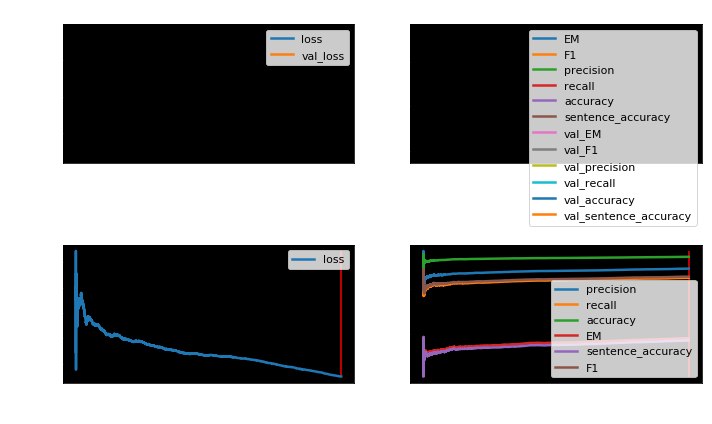

===== History =====
         EM        F1  accuracy      loss  precision   recall  sentence_accuracy    val_EM   val_F1  val_accuracy  \
0  0.583748  0.852154  0.938649  0.237423   0.887084  0.84677           0.574048  0.386458  0.74448      0.884039   

   val_loss  val_precision  val_recall  val_sentence_accuracy  
0  0.580348       0.800226    0.733795                 0.3767  


In [6]:
model.plot_history()
print(model.history)

In [ ]:
pd.DataFrame(model.history.trainings_infos)

In [ ]:
from models.model_utils import get_model_history
from utils import time_to_string

h = get_model_history('m_nq_mag_off_3_12_mean')
pd.DataFrame(h.logs)
time_to_string(13000)

## Evaluate

In [ ]:
model.test(valid, batch_size = 8)
model.save()

In [ ]:
model.test(
    valid, batch_size = 8, max_input_length = 512, negative_mode = 'doc', is_rectangular = 'paragraphs' not in valid.columns,
    max_negatives = 5, max_output_length = 128
)

## Prediction

In [4]:
config = model.get_dataset_config(batch_size = 5, is_validation = True, shuffle_size = 0)
ds = prepare_dataset(valid.sample(25, random_state = 0), ** config, is_rectangular = not use_doc)

for batch in ds:
    model.predict_with_target(batch, n_pred = 10)


Prediction 1 / 5 :
  Input      : <s>What was the percentage of Non-Hispanic Whites in 2010?</s>
  Target     : 30.0%</s>
  Prediction : 30.0%</s>
  Inference  : 30.0%</s>
Prediction 2 / 5 :
  Input      : <s>What term do Islamists think should be applied to them?</s>
  Target     : Muslims</s>
  Prediction : Islam</s>
  Inference  : Islamism</s>
Prediction 3 / 5 :
  Input      : <s>From whom were the movement that Eliot followed derived?</s>
  Target     : William Ellery Channing and Ralph Waldo Emerson</s>
  Prediction : Trans Ellery Channing</s>
  Inference  : Transcendentalist Unitarian convictions</s>
Prediction 4 / 5 :
  Input      : <s>What is the name of the latest epoch?</s>
  Target     : The Holocene</s>
  Prediction : Hol Holocene</s>
  Inference  : Holocene</s>
Prediction 5 / 5 :
  Input      : <s>What type of reaction is present in the emergency oxygen generator of an airplane?</s>
  Target     : exothermic reaction</s>
  Prediction : otherothermic reaction</s>
  Inferenc

In [9]:
question = [
    'How is the night vision of cat ?',
    'How is the night vision of cat ?',
    'What is the anoatomy of a cat ?',
    'How many paws does a cat have ?',
    'How many paws does a cat have ?',
    'How many paws does a cat have ?',
    'What is the origin of life ?'
]
context  = [
    'The cat is similar in anatomy to the other felid species: it has a strong flexible body, \
quick reflexes, sharp teeth and retractable claws adapted to killing small prey. Its night vision and sense of smell are well \
developed. Cat communication includes vocalizations like meowing, purring, trilling, hissing, growling and grunting as well as cat-\
specific body language. A predator that is most active at dawn and dusk (crepuscular), the cat is a solitary hunter but a social species. \
It can hear sounds too faint or too high in frequency for human ears, such as those made by mice and other small mammals.[7] It secretes and \
perceives pheromones.',
    [p.strip() + '.' for p in 'The cat is similar in anatomy to the other felid species: it has a strong flexible body, \
quick reflexes, sharp teeth and retractable claws adapted to killing small prey. Its night vision and sense of smell are well \
developed. Cat communication includes vocalizations like meowing, purring, trilling, hissing, growling and grunting as well as cat-\
specific body language. A predator that is most active at dawn and dusk (crepuscular), the cat is a solitary hunter but a social species. \
It can hear sounds too faint or too high in frequency for human ears, such as those made by mice and other small mammals.[7] It secretes and \
perceives pheromones.'.split('.') if len(p) > 0],
    ['The cat is similar in anatomy to the other felid species: it has a strong flexible body, \
quick reflexes, sharp teeth and retractable claws adapted to killing small prey. Its night vision and sense of smell are well \
developed. Cat communication includes vocalizations like meowing, purring, trilling, hissing, growling and grunting as well as cat-\
specific body language. A predator that is most active at dawn and dusk (crepuscular), the cat is a solitary hunter but a social species. \
It can hear sounds too faint or too high in frequency for human ears, such as those made by mice and other small mammals.[7] It secretes and \
perceives pheromones.', 'The answer to everything is 42'],
    'A cat is an animal which has 4 paws and whiskers.',
    'A cat is an animal which has 4 paws and whiskers. However, everyone knows that the answer to everything is 42 !',
    ['A cat is an animal which has 4 paws and whiskers.', 'However, everyone knows that the answer to everything is 42 !'],
    'The answer to everything is 42.'
]

n = 1
#question, context = question[n], [context[n]]

if not isinstance(question, list): question = [question]
if not isinstance(context, list): context = [context]

answers = model.predict(question, context, title = 'cat')

for q, c, a in zip(question, context, answers):
    print("Question : {}\nContext : {}\nAnswer : {}\n".format(q, c, a))

Question : How is the night vision of cat ?
Context : The cat is similar in anatomy to the other felid species: it has a strong flexible body, quick reflexes, sharp teeth and retractable claws adapted to killing small prey. Its night vision and sense of smell are well developed. Cat communication includes vocalizations like meowing, purring, trilling, hissing, growling and grunting as well as cat-specific body language. A predator that is most active at dawn and dusk (crepuscular), the cat is a solitary hunter but a social species. It can hear sounds too faint or too high in frequency for human ears, such as those made by mice and other small mammals.[7] It secretes and perceives pheromones.
Answer : well developed

Question : How is the night vision of cat ?
Context : ['The cat is similar in anatomy to the other felid species: it has a strong flexible body, quick reflexes, sharp teeth and retractable claws adapted to killing small prey.', 'Its night vision and sense of smell are well 

In [ ]:
from models.qa import AnswerGeneratorSplit
from models.weights_converter import partial_transfer_learning


pretrained = AnswerGeneratorSplit(nom = 'test_nq_qa_generator_split_5_mean')

partial_transfer_learning(model.model, pretrained.model)

In [ ]:
import os
model.load_checkpoint(os.path.join('pretrained_models', 'test_nq_qa_generator_split_5_mean', 'saving'))

In [ ]:
print(model.model.encoder.N)
print(model.model.encoder.hparams)

In [ ]:
model.model.encoder.hparams = model.model.encoder.hparams(subsample_at = -1, subsample_after = True)

In [ ]:
answers = predict(pretrained, question, context)

for q, c, a in zip(question, context, answers):
    print("Question : {}\nContext : {}\nAnswer : {}\n".format(q, c, a))

## Model comparison

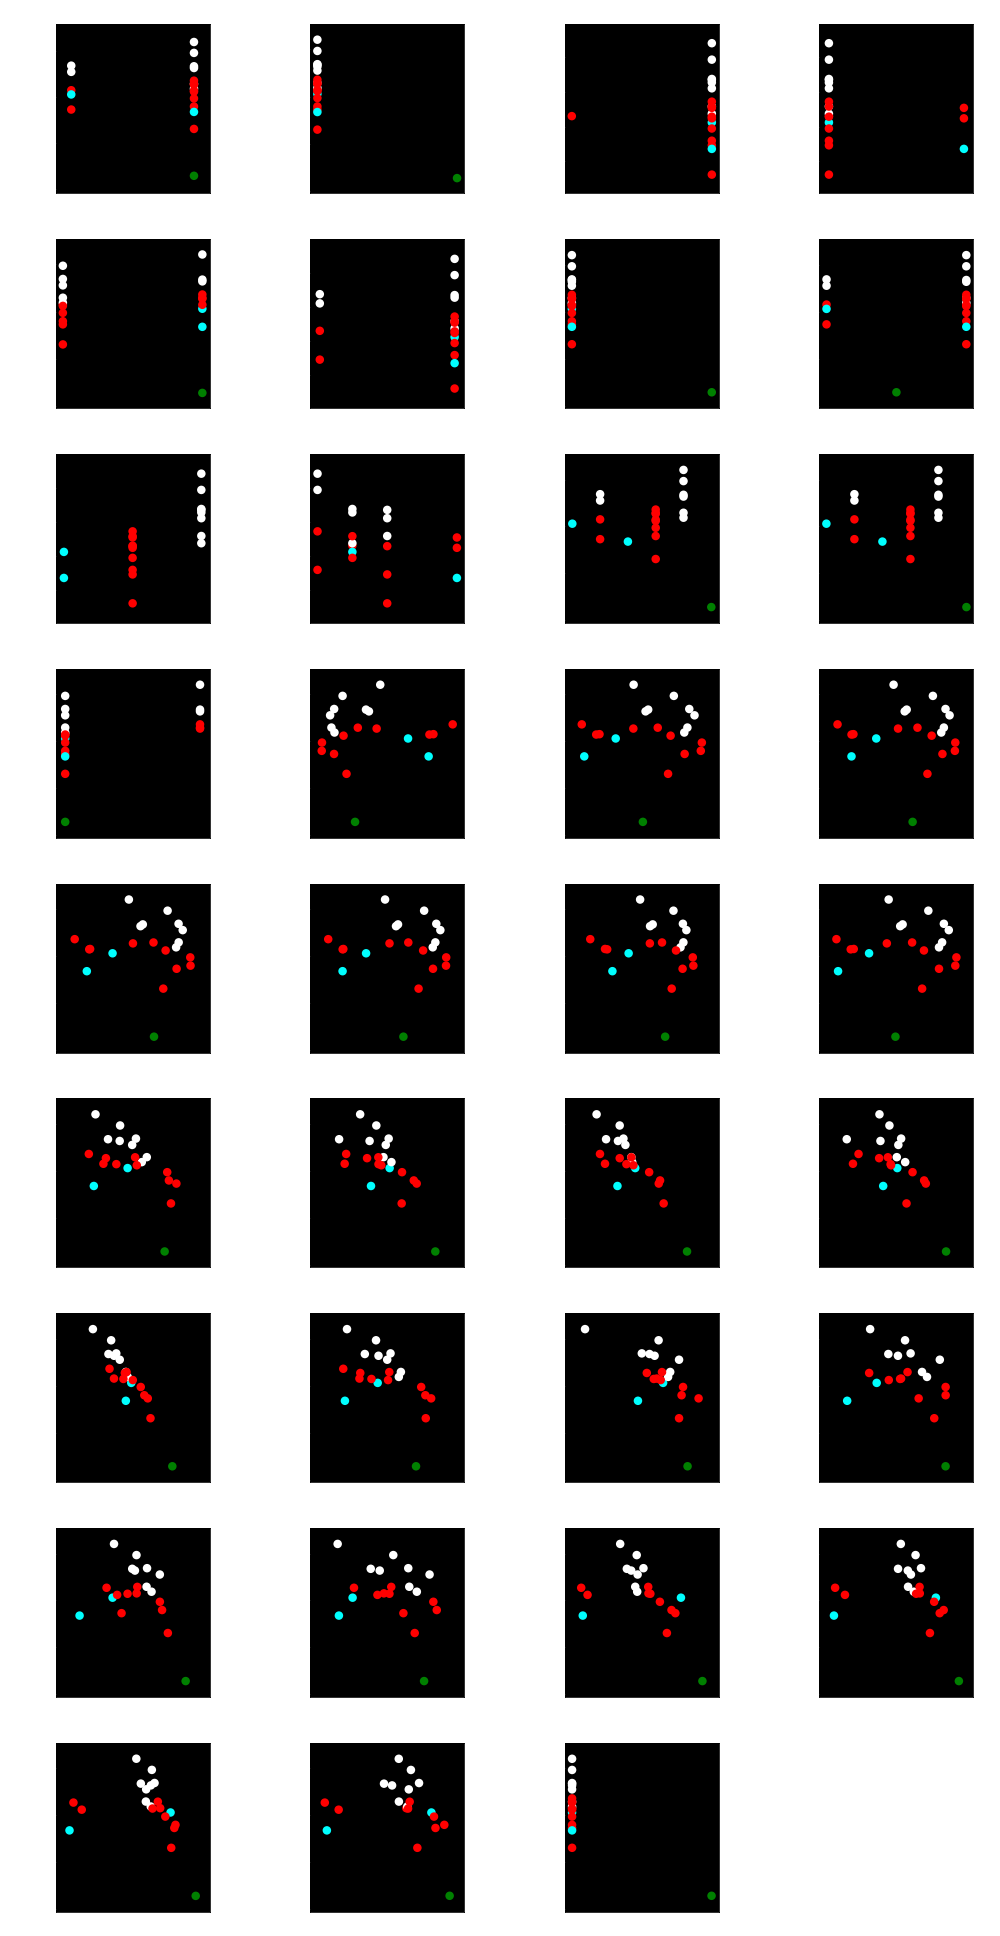

,augment_prct,class,context_offset,encoder_subsample_after,encoder_subsampling_mode,max_negatives,max_output_length,negative_mode,encoder_subsampling_step,encoder_subsample_at,...,val_sentence_accuracy,test_EM,test_F1,test_precision,test_recall,test_squad_EM,test_squad_F1,test_squad_precision,test_squad_recall,input_format
m3_nq,0.25,AnswerGenerator,NaN,NaN,mean,NaN,128,none,NaN,NaN,...,0.372375,0.400495,0.571746,0.731742,0.545861,0.452199,0.664816,0.731414,0.683944,"[{question}, {context}]"
m3_nq_mag_off_entq_ct_wt_ib_2_8_dense,0.25,MAG,128,False,dense,5,96,batch,2,8,...,0.379641,0.387995,0.561136,0.711364,0.536943,0.378842,0.590269,0.662656,0.601457,None
m3_nq_mag_off_entq_ct_wt_ib_1_12_mean,0.25,MAG,128,True,mean,5,96,batch,1,12,...,0.319307,0.327661,0.479581,0.610186,0.464837,0.205128,0.343133,0.376937,0.370123,None
m3_nq_mag_off_entq_ct_wt_ft_doc_2_8_dense,0,MAG,128,False,dense,4,96,doc,2,8,...,0.383663,0.416667,0.546529,0.658286,0.526178,0.396332,0.615451,0.671265,0.647729,None
m3_nq_mag_off_entq_ct_wt_ib_2_4_dense,0.25,MAG,128,False,dense,5,96,batch,2,4,...,0.379332,0.391708,0.571825,0.704732,0.557925,0.388351,0.625687,0.674625,0.670365,None
m3_nq_mag_off_entq_ct_wt_ib_2_6_dense,0.25,MAG,128,False,dense,5,96,batch,2,6,...,0.376238,0.393874,0.571795,0.702212,0.55467,0.364408,0.601142,0.64603,0.643937,None
m3_nq_mag_off_entq_ct_wt_doc_1_6_mean,0,MAG,128,False,mean,5,96,doc,1,6,...,0.34375,0.364583,0.507232,0.648018,0.477866,0.407879,0.605586,0.660718,0.637322,None
m3_nq_mag_off_entq_ct_wt_ib_2_12_dense,0.25,MAG,128,True,dense,5,96,batch,2,12,...,0.351485,0.361077,0.51856,0.653241,0.501489,0.214977,0.371516,0.411316,0.400254,None
m3_nq_mag_off_entq_ct_wt_ib_2_8_mean,0.25,MAG,128,False,mean,5,96,batch,2,8,...,0.339109,0.350866,0.529138,0.665163,0.512913,0.34471,0.554777,0.610103,0.577697,None
m3_nq_mag_entq_ct_wt_ft_doc_2_6_dense,0,MAG,-1,False,dense,4,96,doc,2,6,...,0.330136,0.355198,0.530086,0.675604,0.50764,0.340805,0.564156,0.631611,0.573271,None


In [3]:
import os

from utils import plot_multiple
from models.model_utils import compare_models, remove_training_checkpoint


names = [n for n in os.listdir('pretrained_models') if n.startswith('m3_') and '.' not in n]

# names += [n for n in os.listdir('pretrained_models') if n.startswith('test_mag_')]

infos = compare_models(names, True, True, epoch = 'best', add_training_config = True)
infos = infos.drop(['pretrained_name'], axis = 1)
infos['encoder_subsampling_mode'].fillna('mean', inplace = True)
infos['negative_mode'].fillna('none', inplace = True)


plot_multiple(
    infos[infos['val_loss'] < 1], corr = 'val_loss',
    color_corr = 'encoder_subsampling_step', color_order = ['r', 'w', 'cyan', 'g'],
    ncols = 4, x_size = 3.5, filename = 'mag_plots/val_loss.png', show = True
)
#plot_multiple(infos, corr = 'val_loss', ncols = 3)
infos.sort_values('val_loss')

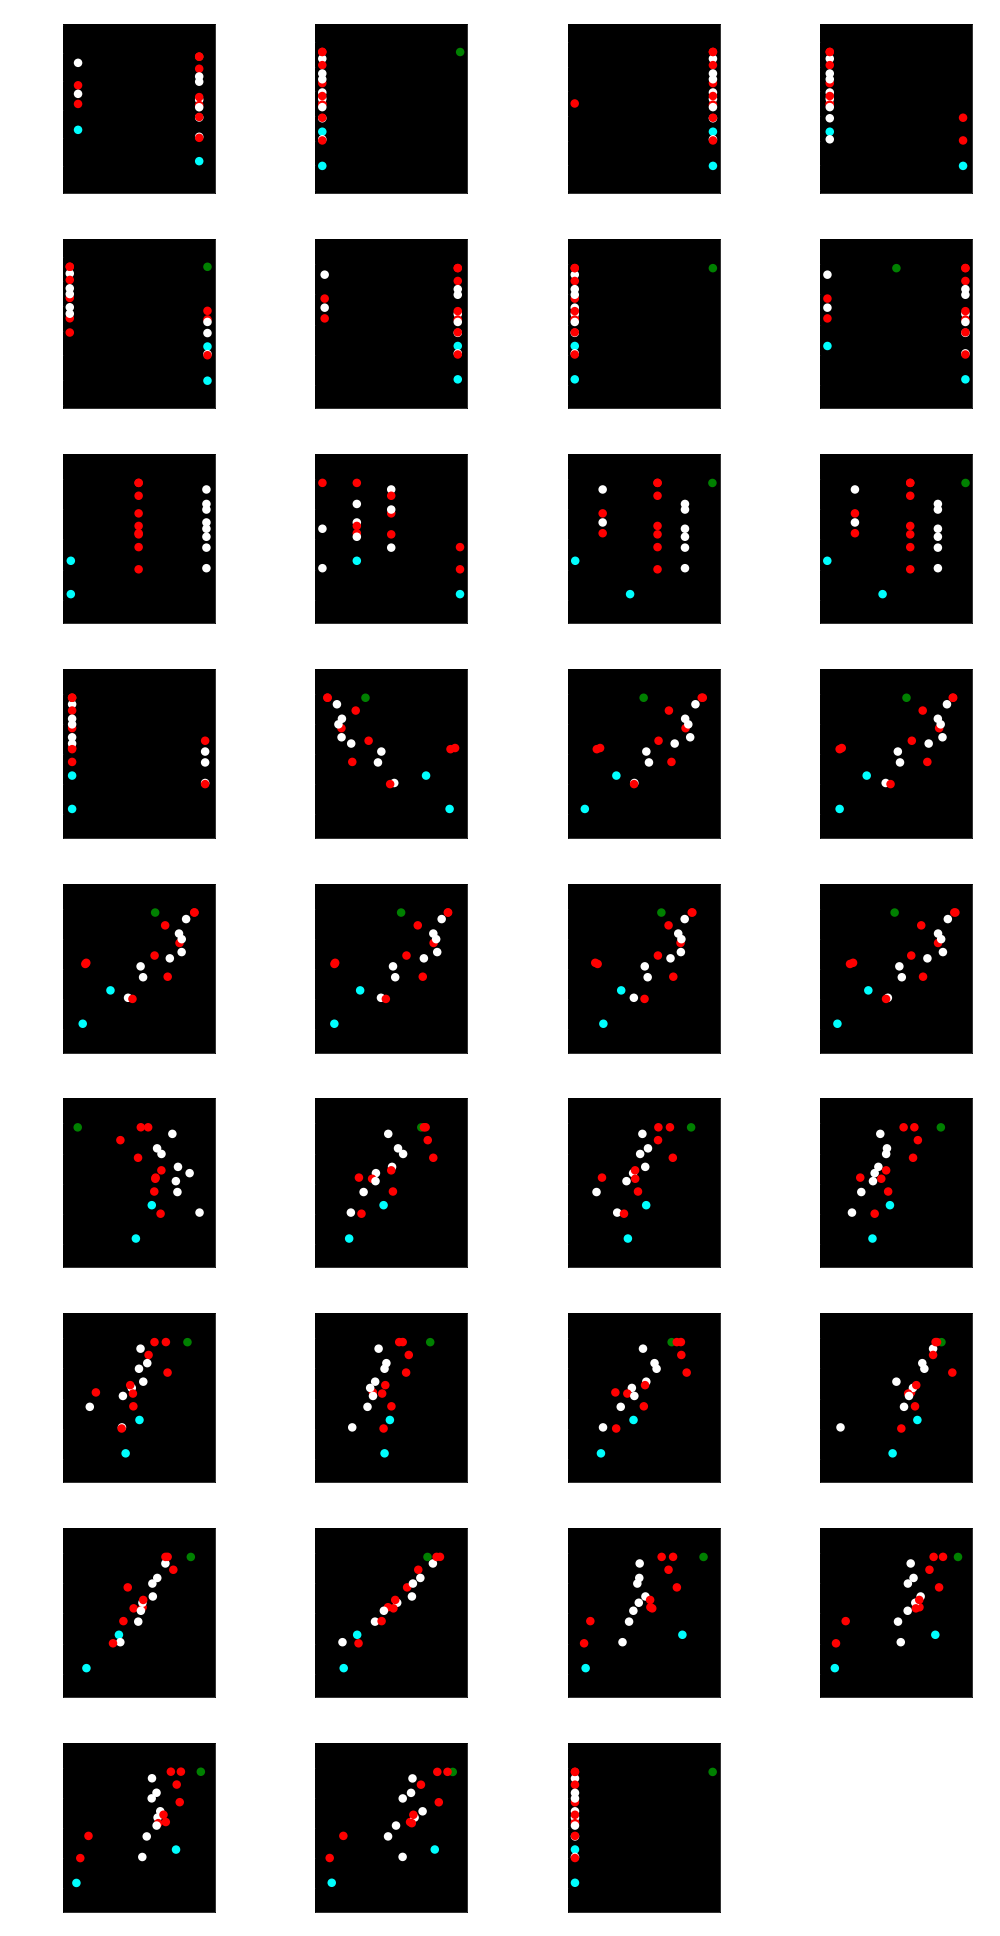

,augment_prct,class,context_offset,encoder_subsample_after,encoder_subsampling_mode,max_negatives,max_output_length,negative_mode,encoder_subsampling_step,encoder_subsample_at,...,val_sentence_accuracy,test_EM,test_F1,test_precision,test_recall,test_squad_EM,test_squad_F1,test_squad_precision,test_squad_recall,input_format
m3_nq_mag_off_entq_ct_wt_ib_2_4_dense,0.25,MAG,128,False,dense,5,96,batch,2,4,...,0.379332,0.391708,0.571825,0.704732,0.557925,0.388351,0.625687,0.674625,0.670365,None
m3_nq_mag_off_entq_ct_wt_ib_2_6_dense,0.25,MAG,128,False,dense,5,96,batch,2,6,...,0.376238,0.393874,0.571795,0.702212,0.55467,0.364408,0.601142,0.64603,0.643937,None
m3_nq,0.25,AnswerGenerator,NaN,NaN,mean,NaN,128,none,NaN,NaN,...,0.372375,0.400495,0.571746,0.731742,0.545861,0.452199,0.664816,0.731414,0.683944,"[{question}, {context}]"
m3_nq_mag_off_entq_ct_wt_ft_doc_3_8_dense,0,MAG,128,False,dense,4,96,doc,3,8,...,0.350866,0.387995,0.566347,0.702141,0.551078,0.31839,0.541284,0.592255,0.579534,None
m3_nq_mag_off_entq_ct_wt_ib_2_8_dense,0.25,MAG,128,False,dense,5,96,batch,2,8,...,0.379641,0.387995,0.561136,0.711364,0.536943,0.378842,0.590269,0.662656,0.601457,None
m3_nq_mag_off_entq_ct_wt_ib_3_6_dense,0.25,MAG,128,False,dense,5,96,batch,3,6,...,0.35953,0.371906,0.554341,0.692665,0.538958,0.317541,0.548743,0.605167,0.575775,None
m3_nq_mag_off_entq_ct_wt_ib_3_8_dense,0.25,MAG,128,False,dense,5,96,batch,3,8,...,0.361077,0.375,0.5497,0.686968,0.53177,0.313466,0.533943,0.591386,0.554241,None
m3_nq_mag_off_entq_ct_wt_ft_doc_2_8_dense,0,MAG,128,False,dense,4,96,doc,2,8,...,0.383663,0.416667,0.546529,0.658286,0.526178,0.396332,0.615451,0.671265,0.647729,None
m3_nq_mag_off_entq_ct_wt_ft_doc_3_6_dense,0,MAG,128,False,dense,4,96,doc,3,6,...,0.353342,0.333333,0.53899,0.6875,0.53081,0.330447,0.567261,0.615769,0.605743,None
m3_nq_mag_off_entq_ct_wt_ib_2_6_mean,0.25,MAG,128,False,mean,5,96,batch,2,6,...,0.352413,0.362933,0.536118,0.676326,0.514638,0.340295,0.563604,0.625012,0.581814,None


In [6]:
plot_multiple(
    infos[infos['val_loss'] < 1], corr = 'test_F1',
    color_corr = 'encoder_subsampling_step', color_order = ['r', 'w', 'cyan', 'g'],
    ncols = 4, x_size = 3.5, filename = 'mag_plots/test_f1.png', show = True
)

infos.sort_values('test_F1', ascending = False)

In [ ]:
import os

from utils import load_json, dump_json

filename = os.path.join('pretrained_models', 'm2_nq_mag_off_entq_ct_wt_ib_3_8_mean', 'saving', 'historique.json')
with open(filename, 'r', encoding = 'utf-8') as file:
    text = file.read()

with open(filename, 'w', encoding = 'utf-8') as file:
    file.write(text.replace('model_loss', 'loss'))


In [2]:
import os

from models.model_utils import remove_training_checkpoint

names = [n for n in os.listdir('pretrained_models') if n.startswith('m_') or n.startswith('m2_')]

for n in names:
    remove_training_checkpoint(n)

## Evaluate all models

In [3]:
import os

from datasets import get_dataset
from models import get_pretrained
from models.model_utils import get_model_history

def test_model(model_name, dataset, test_name, ** kwargs):
    hist = get_model_history(model_name)
    if test_name + '_EM' in hist: return
    
    model = get_pretrained(model_name)
    
    if 'mag' not in model_name:
        kwargs = {k : v for k, v in kwargs.items() if 'negative' not in k}
    
    print(model.test(dataset, test_name = test_name, metrics = ['F1'], add_loss = False, ** kwargs))

def build_dataset(test_name):
    datasets = 'squad' if 'squad' in test_name else 'nq'

    use_doc = True if 'nq' in datasets and 'doc' in test_name else False

    dataset = get_dataset(
        datasets, clean_text = True, skip_impossible = True, keep_only_first = True, shuffle = True, use_long_answer = False,
        include_document = use_doc, modes = ['valid']
    )
    return dataset['valid']

test_name = 'test'

use_doc = True if 'doc' in test_name and 'squad' not in test_name else False

config = {
    'batch_size'    : 12 if not use_doc else 6,
    'max_negatives' : 5,
    
    'negative_mode' : 'batch' if 'ib' in test_name else 'doc' if use_doc else None,
    'teacher_forcing_eval' : True if 'tf' in test_name else False,

    'max_input_length'     : 512,
    'max_output_length'    : 32 * 3,
    'run_eagerly'          : True
}

names = [n for n in os.listdir('pretrained_models') if n.startswith('m3_') and '.' not in n]

dataset = build_dataset(test_name)

for model in names:
    print(model)
    test_model(model, dataset, test_name, ** config)

Loading dataset nq...
m3_nq
m3_nq_mag_entq_ct_wt_ft_doc_2_6_dense
m3_nq_mag_off_entq_ct_wt_doc_1_6_mean
m3_nq_mag_off_entq_ct_wt_ft_doc_2_8_dense
m3_nq_mag_off_entq_ct_wt_ft_doc_3_6_dense
m3_nq_mag_off_entq_ct_wt_ft_doc_3_8_dense
m3_nq_mag_off_entq_ct_wt_ib_1_12_mean
m3_nq_mag_off_entq_ct_wt_ib_1_6_mean
m3_nq_mag_off_entq_ct_wt_ib_2_12_dense
m3_nq_mag_off_entq_ct_wt_ib_2_12_mean
m3_nq_mag_off_entq_ct_wt_ib_2_4_dense
m3_nq_mag_off_entq_ct_wt_ib_2_4_mean
m3_nq_mag_off_entq_ct_wt_ib_2_6_dense
m3_nq_mag_off_entq_ct_wt_ib_2_6_mean
m3_nq_mag_off_entq_ct_wt_ib_2_8_dense
m3_nq_mag_off_entq_ct_wt_ib_2_8_mean
m3_nq_mag_off_entq_ct_wt_ib_3_4_dense
m3_nq_mag_off_entq_ct_wt_ib_3_4_mean
m3_nq_mag_off_entq_ct_wt_ib_3_6_dense
m3_nq_mag_off_entq_ct_wt_ib_3_6_mean
When using token / word-level tokenizer, it can be useful to add 'detach_punctuation' in cleaners
Model restoration...
Initializing submodel : model !
Optimizer 'model_optimizer' initilized successfully !
Successfully restored model from pretr

## Tests

In [ ]:
model.negative_mode = 'doc'
model.max_negatives = 5

config = model.get_dataset_config(batch_size = 16, is_validation = False, shuffle_size = 0)
ds = prepare_dataset(valid, ** config, debug = True, is_rectangular = not use_doc)

test_dataset_time(ds, steps = 1000 if not use_doc else 10)

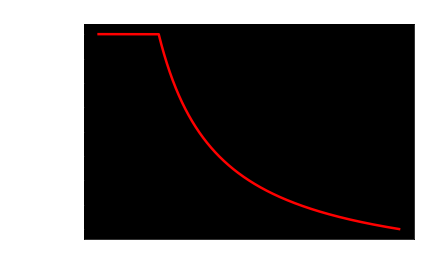

In [6]:
from custom_train_objects.optimizers import WarmupScheduler, DivideByStep

lr = WarmupScheduler(maxval = 5e-5, minval = 5e-6, factor = 32, warmup_steps = 128)
lr = DivideByStep(0.5, maxval = 5e-5, minval = 5e-6)
lr.plot(50000)

In [ ]:
lr = model.get_optimizer().learning_rate
lr.assign(5e-4)

In [ ]:
lr = model.get_optimizer().learning_rate
print(lr)

### Test processing document

In [ ]:
import os
import pandas as pd
import tensorflow as tf

from datasets import get_dataset, prepare_dataset, test_dataset_time
from models.qa import MAG
from utils.text import TextEncoder

dataset = get_dataset('nq', include_document = True)
valid = dataset['valid']

model = MAG(nom = 'm_nq_mag_off_entq_ibt_3_6_mean')

In [ ]:
model.negative_mode = 'doc'
model.force_merging = model.in_batch_negatives
model.max_negatives = 0

config = model.get_dataset_config(batch_size = 2, is_validation = True, shuffle_size = 0)
ds = prepare_dataset(valid.sample(10, random_state = 0), is_rectangular = False, ** config, debug = True)


for batch in ds.take(1):
    print([i.shape for i in batch[0]])
    model(batch[0], training = False, debug = True)
    model.predict_with_target(batch, debug = True)

In [ ]:
ds = dataset['train']
ds['has_valid_idx'] = ds['valid_idx'].apply(lambda idx: idx != -1)
ds['has_valid_idx'].value_counts()

In [ ]:
ds = dataset['train']
ds['contains'] = ds.apply(lambda row: row['answers'] in ('yes', 'no') or row['answers'] in row['context'], axis = 'columns')
ds['contains'].value_counts()

In [ ]:
sub = valid[valid['contains'] == 0]
i0 = sub.iloc[1]
print(i0['question'])
print(i0['answers'])
print(i0['context'])
i0['paragraphs']


In [ ]:
from utils import load_json, dump_json

names = [n for n in os.listdir('pretrained_models') if n.startswith('m_')]

for n in names:
    filename = os.path.join('pretrained_models', n, 'config.json')
    config = load_json(filename)
    if 'in_batch_negatives' in config['config']:
        config['config'].update({
            'negative_mode' : 'batch' if config['config'].pop('in_batch_negatives', None) else None
        })
    # dump_json(filename, config)
    
    